# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.2.0-rc3'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

Using TensorFlow backend.


#### Load Image Data

In [0]:
DATA_LIST = os.listdir('/content/drive/My Drive/ML Class Challenge/Covid_Data_GradientCrescent/all/train')
DATASET_PATH  = '/content/drive/My Drive/ML Class Challenge/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  '/content/drive/My Drive/ML Class Challenge/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [52]:
# raise NotImplementedError("Build your model based on an architecture of your choice "
#                           "A sample model summary is shown below")

model = tf.keras.models.Sequential()

model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3)))
model.add(Flatten(name="flatten"))
model.add(Dense(512, activation="relu",bias_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(4, activation="softmax"))

model.layers[0].trainable=False

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2052      
Total params: 27,562,308
Trainable params: 12,847,620
Non-trainable params: 14,714,688
_________________________________________________________________


#### [5 points] Train Model

In [53]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# raise NotImplementedError("Use the model.fit function to train your network")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=train_batches,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_batches, 
          validation_batch_size=BATCH_SIZE, validation_steps=STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 9s 444ms/step - loss: 4.3906 - accuracy: 0.3190 - val_loss: 1.8334 - val_accuracy: 0.3800
Epoch 2/100
21/21 [==============================] - 9s 434ms/step - loss: 1.9124 - accuracy: 0.5049 - val_loss: 0.9126 - val_accuracy: 0.6400
Epoch 3/100
21/21 [==============================] - 9s 428ms/step - loss: 1.7645 - accuracy: 0.4854 - val_loss: 1.2538 - val_accuracy: 0.5800
Epoch 4/100
21/21 [==============================] - 9s 425ms/step - loss: 1.5208 - accuracy: 0.4563 - val_loss: 1.2533 - val_accuracy: 0.4600
Epoch 5/100
21/21 [==============================] - 9s 421ms/step - loss: 1.0584 - accuracy: 0.5485 - val_loss: 0.8913 - val_accuracy: 0.5600
Epoch 6/100
21/21 [==============================] - 9s 428ms/step - loss: 0.9443 - accuracy: 0.6359 - val_loss: 0.7445 - val_accuracy: 0.6800
Epoch 7/100
21/21 [==============================] - 9s 426ms/step - loss: 0.9630 - accuracy: 0.5971 - val_loss: 0.8840 - val_accuracy: 0.6000

#### [5 points] Plot Accuracy and Loss During Training

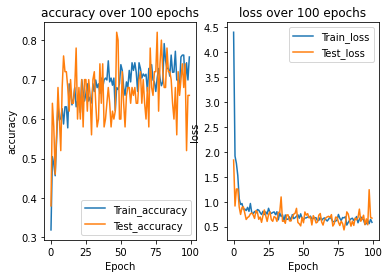

In [55]:
import matplotlib.pyplot as plt

# raise NotImplementedError("Plot the accuracy and the loss during training")

fig, (ax) = plt.subplots(1, 2)

c=0

for i in ['accuracy', 'loss']:
  ax[c].plot(history.history[i], label='Train_'+i)
  ax[c].plot(history.history['val_'+i], label='Test_'+i)
  ax[c].set_xlabel('Epoch')
  ax[c].set_ylabel(i)
  if i=='accuracy':
    ax[c].legend(loc='lower right')
  else:
    ax[c].legend(loc='upper right')

  ax[c].set_title(str(i)+' over '+str(NUM_EPOCHS)+' epochs')
  c+=1

plt.show()

#### Testing Model

In [54]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 36ms/step - loss: 0.7279 - accuracy: 0.7778
Test loss: 0.7279273867607117
Test accuracy: 0.7777777910232544


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [58]:
from sklearn.manifold import TSNE

intermediate_layer_model = Model(inputs=model.input,
                                        outputs=model.get_layer('dense_5').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the four classes.")
activations = intermediate_layer_model.predict(tsne_eval_generator, 1, verbose=1, steps = 270)
tsne = TSNE(n_components=2,init='random', random_state=53)
print(activations.shape)
tsne_obj = tsne.fit_transform(activations)

Found 270 images belonging to 4 classes.
270/270 [==============================] - 9s 33ms/step
(270, 512)


(270, 2)


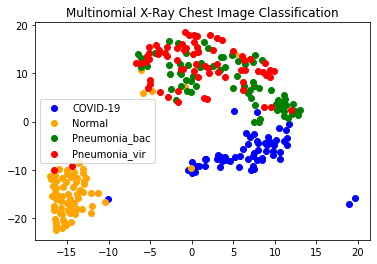

In [59]:
print(tsne_obj.shape)
colors = ['blue', 'orange', 'green', 'red']
c=[colors[i] for i in tsne_eval_generator.labels]
labels = ['COVID-19','Normal', 'Pneumonia_bac', 'Pneumonia_vir']
l=[labels[i] for i in tsne_eval_generator.labels]

x1 = []
y1 = []

for i in range(len(labels)):
  x2 = []
  y2 = []
  for j in range(tsne_obj.shape[0]):
    if(tsne_eval_generator.labels[j]==i):
      x2.append(tsne_obj[j,0])
      y2.append(tsne_obj[j,1])
  x1.append(x2)
  y1.append(y2)

for i in range(len(labels)):
  plt.scatter(x1[i][:], y1[i],c = colors[i],label = labels[i])

plt.title("Multinomial X-Ray Chest Image Classification")
plt.legend()

In [7]:
# raise NotImplementedError("Build your model based on an architecture of your choice "
#                           "A sample model summary is shown below")

model2 = tf.keras.models.Sequential()
model2.add(InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)))
model2.add(Flatten(name="flatten"))
model2.add(Dense(512, activation="relu", name = 'dense_resnet_1', bias_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.30))
model2.add(Dense(4, activation="softmax"))
model2.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense_resnet_1 (Dense)       (None, 512)               19661312  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 74,000,100
Trainable params: 73,939,556
Non-trainable params: 60,544
_________________________________________________________________


In [8]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# raise NotImplementedError("Use the model.fit function to train your network")
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x=train_batches,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_batches, 
          validation_batch_size=BATCH_SIZE, validation_steps=STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 163s 8s/step - loss: 11.9154 - accuracy: 0.2667 - val_loss: 2531.8843 - val_accuracy: 0.1600
Epoch 2/100
21/21 [==============================] - 13s 626ms/step - loss: 2.8187 - accuracy: 0.3252 - val_loss: 18.0100 - val_accuracy: 0.2400
Epoch 3/100
21/21 [==============================] - 13s 629ms/step - loss: 2.5706 - accuracy: 0.2621 - val_loss: 10268.5215 - val_accuracy: 0.2600
Epoch 4/100
21/21 [==============================] - 13s 624ms/step - loss: 2.6146 - accuracy: 0.2184 - val_loss: 3974.1536 - val_accuracy: 0.2200
Epoch 5/100
21/21 [==============================] - 13s 627ms/step - loss: 1.6040 - accuracy: 0.3641 - val_loss: 57.7388 - val_accuracy: 0.3000
Epoch 6/100
21/21 [==============================] - 13s 625ms/step - loss: 1.3769 - accuracy: 0.3252 - val_loss: 10.5625 - val_accuracy: 0.3200
Epoch 7/100
21/21 [==============================] - 13s 616ms/step - loss: 1.2947 - accuracy: 0.3738 - val_loss: 145.2776 -

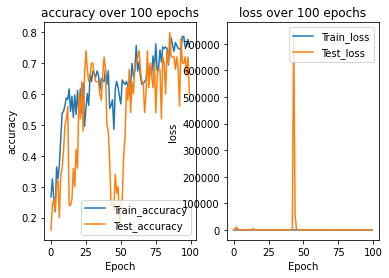

In [9]:
import matplotlib.pyplot as plt

# raise NotImplementedError("Plot the accuracy and the loss during training")

fig, (ax) = plt.subplots(1, 2)

c=0

for i in ['accuracy', 'loss']:
  ax[c].plot(history2.history[i], label='Train_'+i)
  ax[c].plot(history2.history['val_'+i], label='Test_'+i)
  ax[c].set_xlabel('Epoch')
  ax[c].set_ylabel(i)
  if i=='accuracy':
    ax[c].legend(loc='lower right')
  else:
    ax[c].legend(loc='upper right')

  ax[c].set_title(str(i)+' over '+str(NUM_EPOCHS)+' epochs')
  c+=1

plt.show()

In [12]:
test_datagen2 = ImageDataGenerator(rescale=1. / 255)

eval_generator2 = test_datagen2.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator2.reset()
print(len(eval_generator2))
x = model2.evaluate_generator(eval_generator2,steps = np.ceil(len(eval_generator2)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
Instructions for updating:
Please use Model.evaluate, which supports generators.
36/36 [==============================] - 22s 604ms/step - loss: 0.9012 - accuracy: 0.6389
Test loss: 0.9011927843093872
Test accuracy: 0.6388888955116272


In [31]:
from sklearn.manifold import TSNE

intermediate_layer_model2 = Model(inputs=model2.input,
                                        outputs=model2.get_layer('dense_resnet_1').output)

tsne_eval_generator2 = test_datagen2.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the four classes.")
activations2 = intermediate_layer_model2.predict(tsne_eval_generator2, 1, verbose=1, steps = 270)
tsne2 = TSNE(n_components=2,init='random',random_state= 55)
print(activations2.shape)
tsne_obj2 = tsne2.fit_transform(activations2)

Found 270 images belonging to 4 classes.
270/270 [==============================] - 19s 69ms/step
(270, 512)


(270, 2)


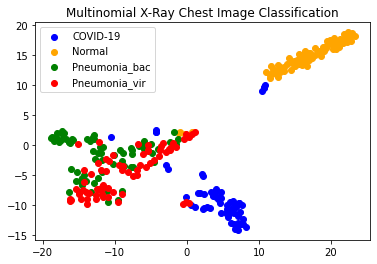

In [32]:
print(tsne_obj2.shape)
colors = ['blue', 'orange', 'green', 'red']
c=[colors[i] for i in tsne_eval_generator2.labels]
labels = ['COVID-19','Normal', 'Pneumonia_bac', 'Pneumonia_vir']
l=[labels[i] for i in tsne_eval_generator2.labels]

x1 = []
y1 = []

for i in range(len(labels)):
  x2 = []
  y2 = []
  for j in range(tsne_obj2.shape[0]):
    if(tsne_eval_generator2.labels[j]==i):
      x2.append(tsne_obj2[j,0])
      y2.append(tsne_obj2[j,1])
  x1.append(x2)
  y1.append(y2)

for i in range(len(labels)):
  plt.scatter(x1[i][:], y1[i],c = colors[i],label = labels[i])

plt.title("Multinomial X-Ray Chest Image Classification")
plt.legend()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->